# How to get started

This series of examples shows the very basics of how to get started with MRPY, using the different functionality. These examples aren't "real world" ones, just toy ones to show the basic idea.

In [1]:
# General Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Core Functionality

Core functionality (i.e. calculation of the MRP function given input parameters,
plus some other functions useful for normalising) is in the ``core`` module:

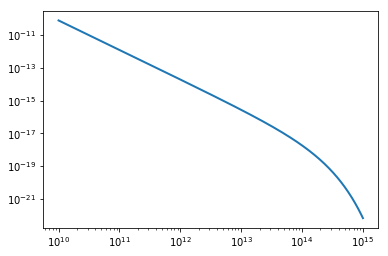

In [2]:
from mrpy import dndm      # resides in the base.core module, but imported into top-level namespace
m = np.logspace(10,15,500) # Create an array of masses
dn = dndm(m, logHs=14.0, alpha=-1.8, beta=0.85) # Create the MRP mass function
plt.plot(m,dn,lw=2)
plt.xscale('log')
plt.yscale('log')

## Pure Stats

If you don't care so much about the fact that the MRP is good for halo mass functions (or don't know what a halo mass function is...), but want to use the statistical distribution, you'll want the ``stats`` module. It contains an object called ``TGGD`` (short for Truncated Generalised Gamma Distribution), which has many statistical quantities and methods available (such as producing random variates, mean, mode etc.)

Mean:  2.84867015869e+14
Mode:  1.21070004341e+14
Variance:  4.79705281452e+28
Mean of sample: 

/home/steven/anaconda2/envs/mrpy/lib/python2.7/site-packages/mrpy/base/stats.py:308: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self.quantile(np.random.uniform(size=n), res_approx=res_approx)


 2.83994695143e+14


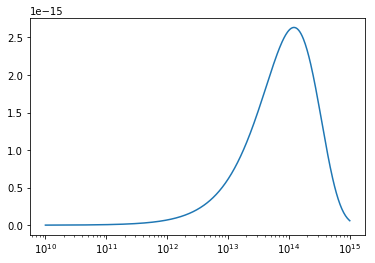

In [4]:
from mrpy import TGGD
tggd = TGGD(scale=1e14,a=1.0,b=0.85,xmin=1e10)
print "Mean: ", tggd.mean  # Mean of the distribution
print "Mode: ", tggd.mode  # Mode of the distirbution
print "Variance: ", tggd.variance # Variance of the distribution
print "Mean of sample: ", np.mean(tggd.rvs(1e5))  #Produce 1e5 random variates and take the mean
plt.plot(m, tggd.pdf(m))      #Plot the PDF
plt.xscale('log')

## Physical Dependence

The ``physical_dependence`` module contains a counterpart to the basic ``dndm`` function, called ``mrp_b13``, which returns the best-fit MRP according to input physical variables (redshift, matter density, rms mass variance). These are
derived from fits to the theoretical mass function of Behroozi+2013.

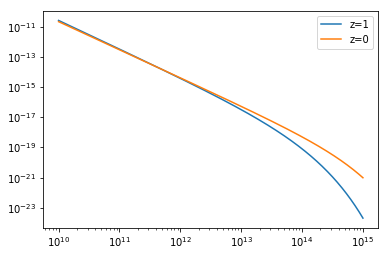

In [5]:
from mrpy import mrp_b13
dndm_z1 = mrp_b13(m,z=1)           # HMF at redshift 1
dndm_z0 = mrp_b13(m,sigma_8=0.85)  # HMF at redshift 0 but sigma_8=0.85
plt.plot(m,dndm_z1,label="z=1")
plt.plot(m,dndm_z0,label="z=0")
plt.legend(loc=0)
plt.xscale('log')
plt.yscale('log')

## Fitting MRP

### Fitting Curve Data

The ``fit_curve`` module contains routines to fit the MRP to binned/curve data. This can be a theoretical curve, or binned halos (or other variates). There are several options available, and the gradient of the objective function is specified analytically to improve performance. See Murray, Robotham, Power, 2016 (in prep.) for more details.

      fun: 0.0030641041050637604
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.07027642,  0.02645665, -0.00225448, -0.07361855])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 31
      nit: 12
   status: 0
  success: True
        x: array([ 14.01049626,  -1.90220807,   0.75724804,  -0.07062159])


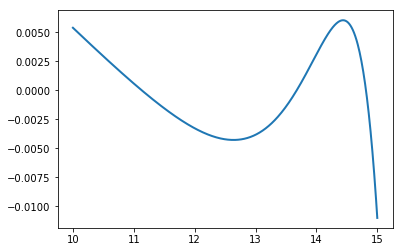

In [12]:
from mrpy.fitting.fit_curve import get_fit_curve
dn = dndm(m,logHs=14.0,alpha=-1.9,beta=0.75,norm=1)
result, curve_obj = get_fit_curve(m,dn,[14.5, -1.8, 0.85,0.],
                                  bounds = [[None,None], [-2,-1.5], [0.2,1.5], [None,None]]) #The bounds argument is very important at this stage.
print result
plt.plot(curve_obj.logm,curve_obj.dndm()/dn-1,lw=2)

In the previous example, we simply fit the four MRP parameters to the input curve. Options can be
specified to constrain the normalisation via the known mean density of the Universe (see MRP, 2017 Appendix C.1 for details).

### Fitting Samples

To fit actual samples of halos, use the ``fit_sample`` module. At this stage, only samples with no measurement uncertainties, and a constant volume (per subsample) are supported. Usefully, this covers the case of output halos from simulations. Within this context, either a downhill-gradient method or MCMC can be used. 

We hope to provide more general fitting scenarios via configuration with other packages in the future.

An example of using the downhill method is as follows:

Resulting Parameters:  [ 14.00643069  -1.8060152    1.06445416 -24.6700997 ]
Hessian at solution:  [[-1839561.07541862  1501113.18335203  -441251.90403259  -427812.69153468]
 [ 1501113.18335203 -1353665.55267563   361418.60222335   355530.40840866]
 [ -441251.90403259   361418.60222335  -107511.02237285  -103181.38312915]
 [ -427812.69153468   355530.40840866  -103181.38312915   -99995.7939758 ]]
Covariance at solution:  [[  4.88260415e-04  -1.67018935e-04   9.60018766e-04  -3.67335827e-03]
 [ -1.67018935e-04   7.34641992e-05  -4.13581385e-04   1.40251375e-03]
 [  9.60018766e-04  -4.13581385e-04   3.29110519e-03  -8.97367500e-03]
 [ -3.67335827e-03   1.40251375e-03  -8.97367500e-03   2.99718783e-02]]


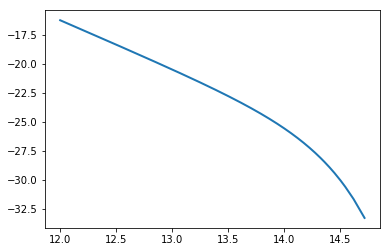

In [15]:
from mrpy.base.stats import TGGD
from mrpy.fitting.fit_sample import SimFit

# Create some mock data to fit
r = TGGD(scale=1e14,a=-1.8,b=1.0,xmin=1e12).rvs(1e5)
r = np.sort(r)

# Create fit object, specifying parameter bounds
fitobj = SimFit(r,hs_bounds=(12,16),alpha_bounds=(-1.99,-1.6),beta_bounds=(0.5,1.5))

# Run downhill gradient method
res, obj = fitobj.run_downhill()

# Print the resulting parameters
print "Resulting Parameters: ", res.x

# The "obj" returned is a list of PerObjLike objects defined at the result, containing lots of methods and quantities:
print "Hessian at solution: ", obj[0].hessian
print "Covariance at solution: ", obj[0].cov

# Plot the mass function from obj (the logm contains all the masses from the fit)
plt.plot(obj[0].logm,obj[0].dndm(log=True),lw=2)